In [1]:
#fundamental tools for the game environment model
import numpy as np
import multiprocess
from multiprocess import Process, Queue, Semaphore, Lock
import time
import random

# for visualations
import matplotlib.pyplot as plt

In [2]:
from randomchooser import Chooser
from exploresims import simulate_explore, sim_1, demo_1, demo_2
import explore

pygame 2.5.1 (SDL 2.28.2, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


When training a Reinforcement Learning (RL) model using a variation of Temporal Difference Error and discrete actions, it is overwhelmingly common to both emphasize the importance of input/action variance and to control output variance and bias.

One is far more likely to encounter discussion, advice, and research pertaining to the controlling of the variance in the outputs of a model. This is the so-called Variance or Bias Tradeoff (VBT). The problem here is of course the repetitive use of the term Variance, but given its statistical significance this is mostly unavoidable.

This discussion and its accompanying demonstrations are focused on the other side of the spectrum. The variance of the experiences provided to the model during training. How actions are selected and its impact on model convergence, and potentially the quality of the policy, overall.

For simplicity of the demonstrations, we shall focus our considerations to RL models most similar to DQN models utilizing algorithms that mathematically resemble the Epsilon Greedy Strategy and Experience Replay Memory in line with Bellman Equation based policy optimizations (i.e. Deep Reinforcement Learning / Deep Q-Learning).

Note this restriction is arbitrary and simply serves to limit the scope of the demonstration, to keep things accessible, apologies to the more advanced reader.

Unlike the plethora of sources that discuss the Variance Bias Tradeoff of outputs, there are far less discussions on maximizing or minimizing the variance of actions selected by the model during its exploratory phases. It is quite the norm for texts, tutorials, examples, and the like to simply select a uniform distribution, justify it as being mathematically the highest variance, and therefore the least biased towards any one action type for the model to explore and move on.

This is fine in theory, it feels intuitive, however this trend should not go unchallenged simply for its face value.

The reasoning here is that we want high variance in the random actions selected during exploration. The point is that we want the model, for a time, to make entirely random moves. These moves should not "prefer" any one action and build a stored memory of experiences. Then we slowly allow the model to take its own actions and converge on some strategy. This is the fundamental idea behind the Epsilon Greedy strategy.

High variance in the random selection ensures a diverse set of experiences and the uniform nature of the distribution prevents bias in examples. This is why the common assumption is so intuitive and is rarely strayed from, or challenged.

To avoid this from being an endless drone, lets dip our toes in and  see some demonstrations and other visualizations. To this end I have put together a small game, called Explore. It is like a simple maze game, where an agent, or player, is represented by a blue square and must navigate to the exit or goal, represented by the green square.
There may be some number of gray walls obstructing the agent's path, but a path to the goal will always exist.
The agent may only choose to move up, down, left, right, or do nothing.

For visualization purposes the animation includes a trace or heatmap of the number of times a square has been visited. This matrix is then normalized such that the most visited square is always full white, and unvisited squares are fully black.
Please run the next cell and observe this first agent "play". I won't mention what algorithm may be at play here, yet, but know the moves are entirely random.
10 games will be simulated, up to 80 moves each. The trace will be totaled over all 10 games.

Note these first two demos will not have the walls in play.
The windows will hold the result for a few seconds before closing so you can view the final heatmap. Focus on the look and feel of the gameplay you see.

In [34]:
sample_1 = demo_1()

In [35]:
# Now watch this other demo
sample_2 = demo_2()

Okay now watch them again, but with the walls present so you can see what the game would be like in general. If an agent gets to the goal, it progresses to the next "floor". As in a new map, and goal location is generated. You may have seen the goal move earlier when touched, but now it will include a whole new map. Reaching the goal 10 times is the offical "win" condition of the game.

In [7]:
demo_1(rebuild=True)
demo_2(rebuild=True)

Okay so now you have watched two different "agents" play a few games. I already told you the first one was random . . . but would you beleive me if I told you the second one was equally as random?

Assuming you are infact willing to beleive me, here is a question I want you to ponder.

Which one was more random?

Feel free to watch them play again if you like but don't get to caught up in trying to guess correctly. The nebulous nature of this randomness is indeed the reason for this demo.

Okay here is another question, which heatmap or trace, the thing on the right of the viewing window looks the most variable?

Don't worry we saved them earlier so you don't have to keep running the simualtion to look at them.

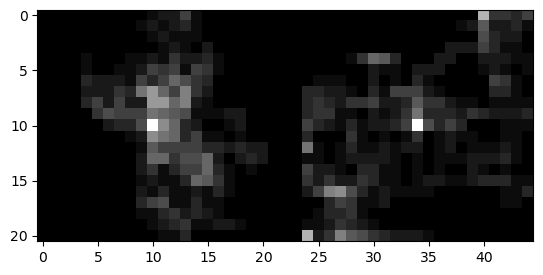

In [42]:
#This is just some postprocessing for drawing the heat maps
heat_1 = sample_1[0][4].copy()
heat_2 = sample_2[0][4].copy()

# normalizing here to retain relative maxima brightness for each map
# imshow also runs a normalize 
# and would use the max out of both maps to normalize both
# If you are interested, you can try commenting them out
# but randomness plays a role here as well
heat_1 *= 255/heat_1.max()
heat_2 *= 255/heat_2.max()

# To visually separate the two heat maps
spacer = np.zeros((21,3))

img = np.hstack([heat_1, spacer, heat_2])
plt.imshow(img, cmap="gray")

In [26]:
max_processors = min(8, max(1, multiprocess.cpu_count()//2))
#Game params
game_size = 21
use_maze = False
use_exclusion = True
use_noise_boundary = 2
game_sparsity = .8

game_args = [game_size, use_maze, use_exclusion, use_noise_boundary, game_sparsity]

game_window_size = 300
game_window_framerate = 60

window_args = [game_window_size, game_window_framerate]


In [27]:
choosers = []
choosers.append(Chooser(5))
if False:
    for i in range(3, 13):
        choosers.append(Chooser(5, [0,10,7.5,5,0], i))
    for i in range(3, 13):
        choosers.append(Chooser(5, [10,10,10,10,10], i))
    for i in range(3, 13):
        choosers.append(Chooser(5, [1,10,10,10,0], i))
else:
    choosers.append(Chooser(5, [0, 10, 7.5, 5, 0], 6))
    choosers.append(Chooser(5, [0, 10, 7.5, 5, 0], 4))
    choosers.append(Chooser(5, [0, 10, 7.5, 5, 0], 5))
    choosers.append(Chooser(5, [1, 10, 10, 10, 0], 7))
len(choosers)

5

In [28]:
out = sim_1(choosers, samples=1000, games=10, turns=40, num_process=8, num_column=3, env_args=game_args, window_args=window_args)

In [29]:
results = out

In [30]:
for k in range(len(results)):
    max_winrate = 0
    pos = 0
    for i in range(k, len(results)):
        if results[i][2][0] > max_winrate:
            max_winrate = results[i][2][0]
            pos = i
    temp = results[k]
    results[k] = results[pos]
    results[pos] = temp

In [31]:
for i in range(len(results)):
    print(results[i][2][0])

0.231
0.228
0.216
0.175
0.088


In [19]:
weights = []
durations = []
win_data = []
stdev_data = []
trace_averages = []
for result in results:
    weights.append(result[0])
    durations.append(result[1])
    win_data.append(result[2])
    stdev_data.append(result[3])
    trace_averages.append(result[4])

In [20]:
for (w, d, r) in zip(weights, durations, win_data):
    print(d, w, f"{r[0]:.4}", f"{r[2]:.3}", " <--> ", f"{r[0] - r[2]:.4}", " - ", f"{r[0] + r[2]:.4}")

7 [1, 10, 10, 10, 0] 0.977 0.0326  <-->  0.9444  -  1.01
5 [0, 10, 7.5, 5, 0] 0.946 0.0319  <-->  0.9141  -  0.9779
4 [0, 10, 7.5, 5, 0] 0.933 0.0302  <-->  0.9028  -  0.9632
6 [0, 10, 7.5, 5, 0] 0.895 0.0312  <-->  0.8638  -  0.9262
-1 None 0.732 0.0269  <-->  0.7051  -  0.7589


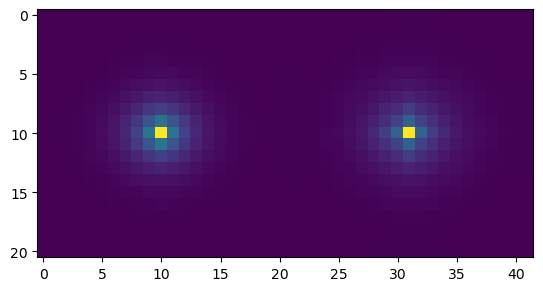

In [13]:
temp = np.hstack([trace_averages[-2], trace_averages[0]])
plt.imshow(temp)

In [43]:
mins = np.zeros(len(trace_averages))
for i in range(len(trace_averages)):
    mins[i] = trace_averages[i].min()
mins.mean()

1.4395645161290322

In [44]:
mins.std()

0.5024933281844916

In [38]:
trace_averages[-1].max()

524.6467

In [39]:
trace_averages[0].max()

489.7545

In [ ]:
#6 [0, 10, 7.5, 5, 0] 7.37 0.0274  <-->  7.343  -  7.398
#4 [0, 10, 7.5, 5, 0] 7.354 0.0276  <-->  7.326  -  7.381
#5 [0, 10, 7.5, 5, 0] 7.318 0.0275  <-->  7.291  -  7.346
#7 [1, 10, 10, 10, 0] 7.31 0.0277  <-->  7.282  -  7.337

In [10]:
win_averages = []
win_stds = []
win_errors = []
for win in win_data:
    win_averages.append(win[0])
    win_stds.append(win[1])
    win_errors.append(win[2])

In [11]:
stdev_averages = []
stdev_stds = []
stdev_errors = []
for stdev in stdev_data:
    stdev_averages.append(stdev[0])
    stdev_stds.append(stdev[1])
    stdev_errors.append(stdev[2])

In [12]:
for (mean, error) in zip(stdev_averages, stdev_errors):
    print(mean, error)

21.915006421778063 0.10708246384246096
15.2103472534303 0.08477570267273185
16.418986514123485 0.08330403448770658
17.957885942316455 0.082570717415026
19.480932797157642 0.08758232776463426
21.781383165100706 0.09574792182765507
15.629925028396283 0.08976795817382
13.687060319755307 0.06589713849537174
14.736647638912821 0.08364109341070006
14.072948662005137 0.08261498998746902
13.682836146118154 0.09185016762984498
14.127084552989043 0.08014547039543578


In [3]:
ch1 = Chooser(5)
ch2 = Chooser(5, [1,10,10,10,1])

In [5]:
lol1 = Process(target=simulate_explore, args=[sem, out_lock, output_queue, 100,100,40, ch1, 15, 1.08])
lol2 = Process(target=simulate_explore, args=[sem, out_lock, output_queue, 100,100,40, ch2, 15, 1.08])

In [6]:
lol1.start()
lol2.start()

In [8]:
lol1.join()
lol2.join()

In [10]:
list = []
if list:
    print("hi")